In [2]:
import numpy as np
import matplotlib
import astropy.units as u
from astropy.coordinates import AltAz, EarthLocation, SkyCoord
from astropy.time import Time
from datetime import datetime

from ugradio import leusch

import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [12, 10]

! potential azimuth issue: ~5.2

In [4]:
# leusch
LOC = EarthLocation(lat=37.91934*u.deg, lon=122.15385*u.deg, height=304*u.m)
ALT_MIN, ALT_MAX = leusch.ALT_MIN, leusch.ALT_MAX
AZ_MIN, AZ_MAX = leusch.AZ_MIN, leusch.AZ_MAX

def galactic_to_altaz(coord, time):
    l, b = coord
    g_sc = SkyCoord(frame="galactic", l=l*u.deg, b=b*u.deg)
    altaz_sc = g_sc.transform_to(AltAz(obstime=time, location=LOC))
    return altaz_sc.alt.degree, altaz_sc.az.degree

def observable_time(coord, time):
    '''
    given:
    target (source) in galactic coordinates [LAT, LON]
    time as an astropy time object
    
    assume:
    location of telescope 
    range of telescope
    
    return:
    a "countdown time" for the target coordinate 
    that counts the **relative quantity of observable altitude degrees**
    until it is no longer in observable range
    (not precise)
    '''
    alt, az = galactic_to_altaz(coord, time)
    if (ALT_MIN < alt < ALT_MAX) and (AZ_MIN < az < AZ_MAX):
        if 0 <= az < 180:
            p = (ALT_MAX - alt) + (ALT_MAX - ALT_MIN)
        else:
            p = alt - ALT_MIN
    else:
        p = 0
    assert p >= 0, 'bad p'
    return p
    

In [51]:
orion_center = [189.32709197, -36.54216867]

t = Time(datetime.now())
print('orion')
print(f'time now: {t.value}')
print(f'altaz now: {galactic_to_altaz(orion_center, t)}')
print(f'observable now: {observable_time(orion_center, t) > 0}')

orion
time now: 2023-04-18 14:46:14.739363
altaz now: (-29.54279535116044, 297.69216577792633)
observable now: False


Text(0, 0.5, 'estimate: remaining observable altitude [degrees]')

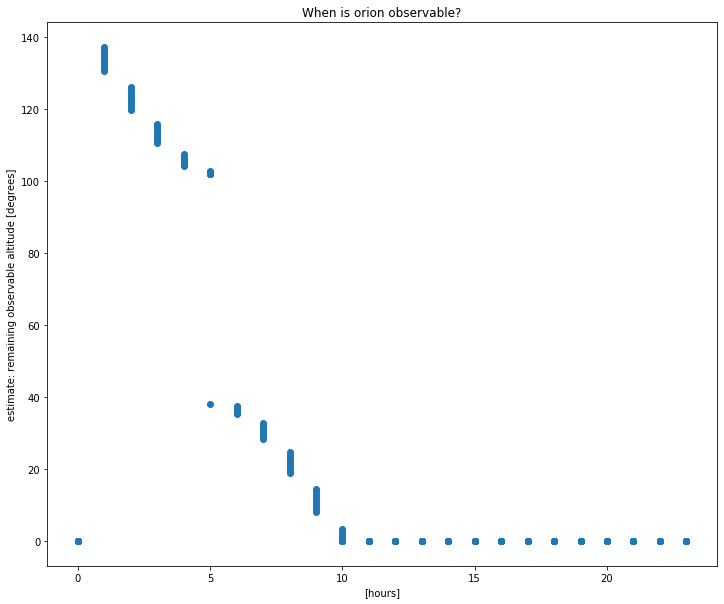

In [48]:
future = 24*10 # hours
times = Time(datetime.now()) + range(future)*u.h
result = {}
for t in times:
    result[t.value] = observable_time(orion_center, t)

x = [dt.hour for dt in list(result.keys())]
y = list(result.values())
plt.scatter(x, y)
plt.title('When is orion observable?')
plt.xlabel('[hours]')
plt.ylabel('estimate: remaining observable altitude [degrees]')